# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

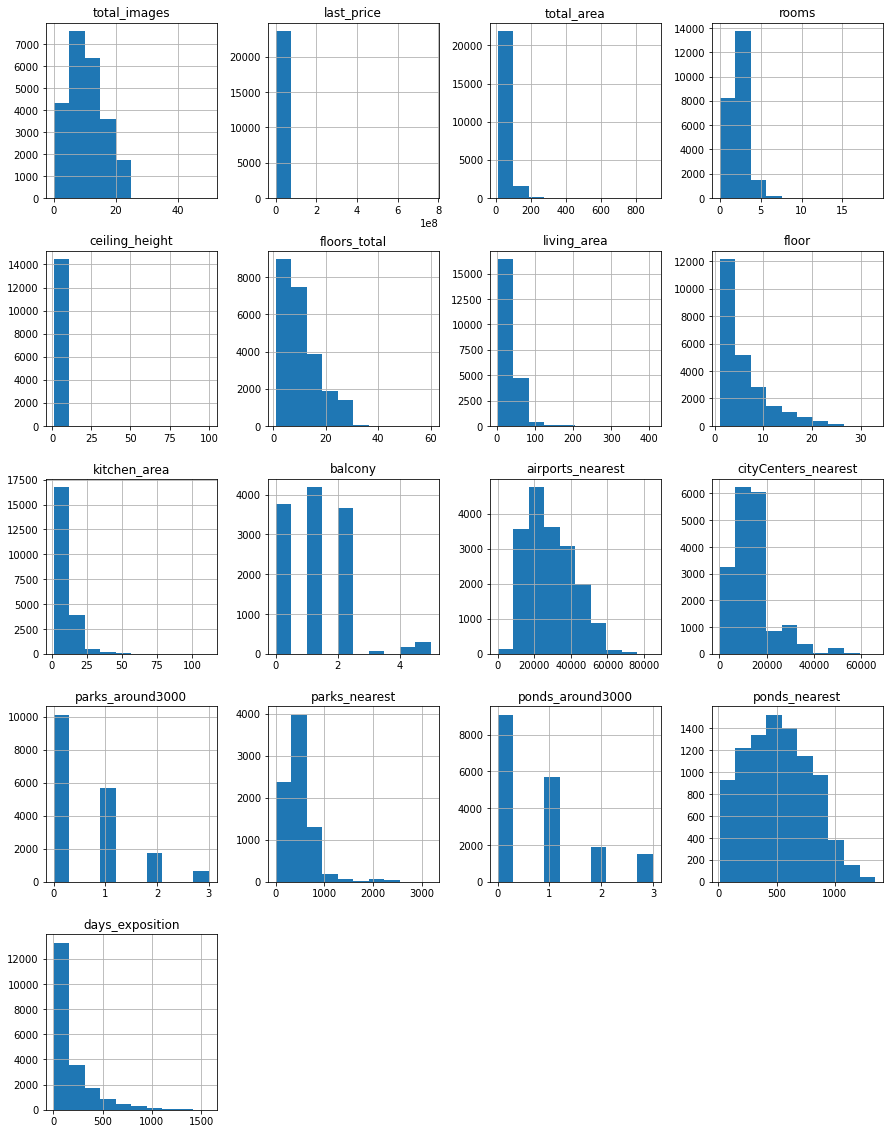

In [4]:
data.hist(figsize=(15,20))
plt.show()

*Вывод:* на построенных гистограммах видно наличие выбросов и нелогичных значений 

### Выполните предобработку данных

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['locality_name'] = data['locality_name'].fillna('неизвестен')

По аналогии с количеством балконов можем заполнить нулями: parks_around3000, ponds_around3000

однако, то, что касается метража или конкретного рассояния до объекта - мы не можем логически предположить значения

также я заполнила столбец 'locality_name' с помощью 'неизвестен', так как дальше мы будем работать с этим столбом 

*причина возможных появлений пропусков*: человеческий фактор (пропустили/забыли написать) или сбой в системе

In [7]:
data[data['parks_around3000'] == 0].head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,NaN,12.0,14.4,5,NaN,...,9.1,0.0,городской посёлок Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,NaN,26.0,10.6,6,NaN,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0


In [8]:
data[(data['parks_around3000'] != 0) & (data['locality_name'] == 'городской посёлок Янино-1')].head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [9]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [10]:
data['parks_around3000'] = data['parks_around3000'].astype('int32')
data['ponds_around3000'] = data['ponds_around3000'].astype('int32')

*Объяснение изменения типов данных:*

метраж, цена могут быть дробными числами, поэтому тип данных float64 в соответствующих столбцах не менялся

но количество объектов может быть только целочисленным, поэтому в столбцах parks_around3000, ponds_around3000 был изменен тип данных на int64

In [11]:
data['locality_name'].unique(), len(data['locality_name'].unique())

(array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
        'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
        'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
        'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
        'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
        'деревня Новое Девяткино', 'посёлок Металлострой',
        'посёлок городского типа Лебяжье',
        'посёлок городского типа Сиверский', 'поселок Молодцово',
        'поселок городского типа Кузьмоловский',
        'садовое товарищество Новая Ропша', 'Павловск',
        'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
        'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
        'поселок городского типа Ефимовский', 'посёлок Плодовое',
        'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
        'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
        'дерев

*Найдены неявные дубликаты:* 
Мурино посёлок Мурино поселок Мурино
поселок городского типа Рябово поселок Рябово

In [12]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].replace('Мурино', 'поселок Мурино')
data['locality_name'] = data['locality_name'].replace('поселок городского типа Рябово', 'поселок Рябово')


In [15]:
data['locality_name'].unique(), len(data['locality_name'].unique())

(array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
        'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
        'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
        'поселок городского типа Красный Бор', 'Гатчина',
        'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
        'деревня Новое Девяткино', 'поселок Металлострой',
        'поселок городского типа Лебяжье',
        'поселок городского типа Сиверский', 'поселок Молодцово',
        'поселок городского типа Кузьмоловский',
        'садовое товарищество Новая Ропша', 'Павловск',
        'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
        'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
        'поселок городского типа Ефимовский', 'поселок Плодовое',
        'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
        'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
        'деревня Лесколово', 'по

*Вывод:* после удаления неявных дубликатов количество уникальных значений столбца 'locality_name' сократилось с 365 до 329

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [16]:
data['rooms'].max(), data['rooms'].mean()

(19, 2.070635891809781)

In [17]:
data['living_area'].max(), data['living_area'].mean(), data['living_area'].min()

(409.7, 34.457852427601395, 2.0)

In [18]:
data['ceiling_height'].max(), data['ceiling_height'].mean(),data['ceiling_height'].min()

(100.0, 2.77149889685604, 1.0)

In [19]:
data['balcony'].max(), data['balcony'].mean()

(5.0, 0.5910797923963036)

In [21]:
data = data.query('rooms <= 4 and living_area <= 100 and ceiling_height <= 35 and living_area >= 20 and ceiling_height >= 2')

*Объяснение:* выбрала высоту потолков до 35м исходя из пукнта 4, где сказано, что 32м это скорее всего 3.2м,
остальное все по логике

*Вывод:* были расчитаны средние, максимальные и минимальные значения столбцов, где могли находиться экстремальные значения.

Методом query() была произведена фильтрация строк для очистки data

<div class="alert alert-block alert-info">
    Исправила
</div>

### Добавьте в таблицу новые столбцы

In [22]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,loсality_name
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,0.0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,Санкт-Петербург
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,0.0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург
9,18,5400000.0,61.0,2017-02-26T00:00:00,3,2.50,9.0,43.6,7,NaN,...,2.0,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0,Санкт-Петербург
10,5,5050000.0,39.6,2017-11-16T00:00:00,1,2.67,12.0,20.3,3,NaN,...,0.0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137.0,Санкт-Петербург
13,20,3550000.0,42.8,2017-07-01T00:00:00,2,2.56,5.0,27.0,5,NaN,...,1.0,Петергоф,37868.0,33058.0,1,294.0,3,298.0,366.0,Петергоф


In [23]:
data['price_for_meter'] = (data['last_price'] / data['total_area']).round(2)

In [24]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data['day_exposition'] = data['first_day_exposition'].dt.dayofweek

In [25]:
data['month_exposition'] = data['first_day_exposition'].dt.month

In [26]:
data['year_exposition'] = data['first_day_exposition'].dt.year

In [27]:
def determine_floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['type_floor'] = data.apply(determine_floor_type, axis=1)

In [28]:
import numpy as np
data['city_center_km'] = data['cityCenters_nearest'].apply(
    lambda x: round(x / 1000) if pd.notna(x) else np.nan)

### Проведите исследовательский анализ данных

Список параметров:
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего парка

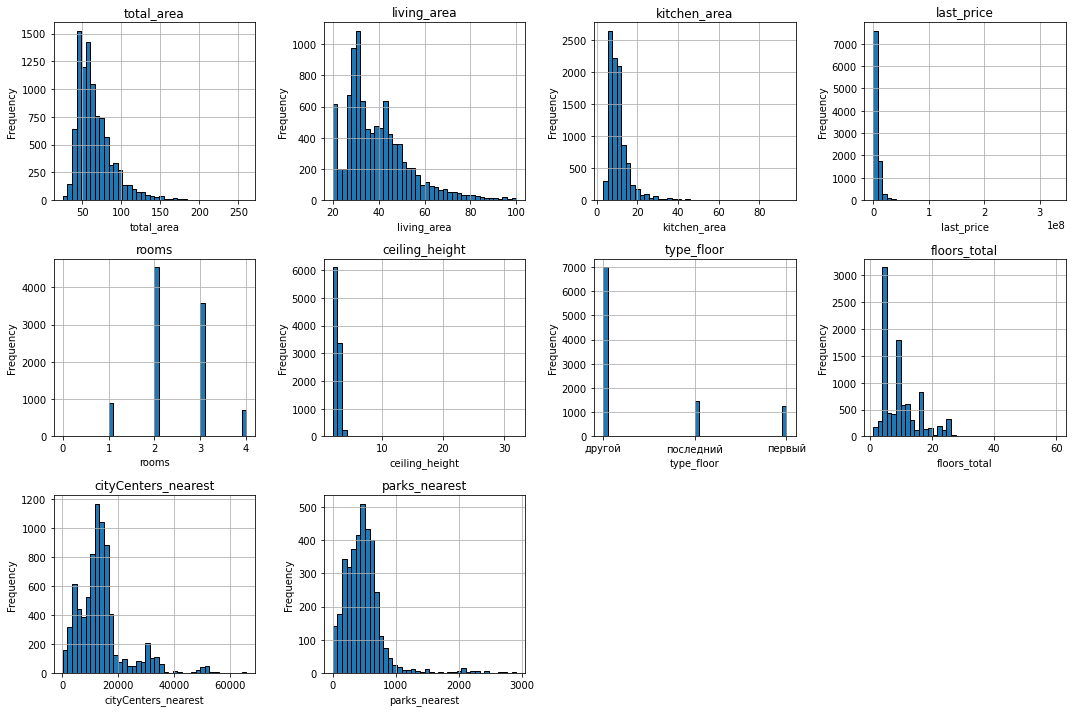

In [29]:
columns_to_plot = [
    'total_area',
    'living_area',
    'kitchen_area',
    'last_price',
    'rooms',
    'ceiling_height',
    'type_floor',
    'floors_total',
    'cityCenters_nearest',
    'parks_nearest'
]

plt.figure(figsize=(15, 10))

for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 4, i + 1) 
    data[column].hist(bins=40, edgecolor='black')
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')


plt.tight_layout()
plt.show() 

In [30]:
data['total_area'].max()

260.0

*Анализ экстремальных значений(выбросов)*

1. total_area: выбросы при >150м
2. living_area: уже обработано на прошлом этапе
3. kitchen_area: выбросы >40м
4. last_price: выбросы >0.4 * 10^8
5. ceiling_height: логическое изменение экстремальных значений путем деления на 10
6. cityCenters_nearest: выбросы >55000м
7. parks_nearest: выбросы >15000м

<div class="alert alert-block alert-warning">
 
### Комментарий ревьюера
    
#### Совет

Вот тут давай привыкнем оформлять графики правильно. Не забывай давать им названия. Сделать это можно командой title()

In [32]:
data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x / 10 if x >= 20 else x)

In [33]:
data = data.query('total_area <= 150 and kitchen_area <= 40 and last_price <= 40000000 and ceiling_height <= 3.5 and cityCenters_nearest <= 55000 and parks_nearest <= 15000')

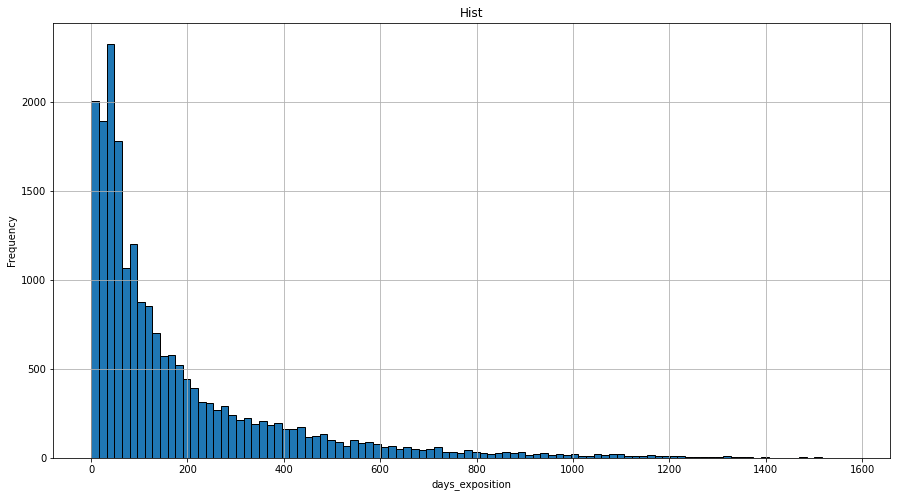

In [22]:
data['days_exposition'].hist(bins = 100, figsize=(15,8), edgecolor='black')
plt.title('Hist')
plt.xlabel('days_exposition')
plt.ylabel('Frequency')
plt.show()

<div class="alert alert-block alert-danger">
 
### Комментарий ревьюера
    
#### Ошибка

А тут стоило рассмотреть график чуть подробнее. На нем будет несколько выбросов. Нужно их показать на графике и высказаться о причинах появления.

<div class="alert alert-block alert-info">
    Я изменила оформление графика, добавила title и подписи для осей, также изменила количество корзин для более наглядной визуализации, воспользовалась plt.show().
    Ниже написала возможные причины возникновения выбросов
</div>

<div class="alert alert-block alert-success">
 
# Комментарий ревьюера ver.2 
    
#### Успех

Отлично. Выбросы тут появились по причине того, что в эти дни система убирает с показа бесплатные объявления. 

In [20]:
data['days_exposition'].mean(), data['days_exposition'].min()

(180.88863436982163, 1.0)

In [36]:
data['days_exposition'].median()

114.0

In [37]:
quantile_15 = data['days_exposition'].quantile(0.15)
quantile_85 = data['days_exposition'].quantile(0.85)

print(f"15-й квантиль: {quantile_15}")
print(f"85-й квантиль: {quantile_85}")

15-й квантиль: 26.0
85-й квантиль: 392.2999999999997


*Возможные причины возникновения выбросов:*
1. Системный сбой
2. Человеческий фактор, неправильно указали количество дней, если эти данные заполнялись вручную

*Объяснение:*
среднее более чуствительно к выбросам, поэтому я буду оперировать медианой
1. Среднее время продажи ~114 дней
2. Экстремально быстрые продажи до 26 дней
3. Экстремально долгие от 392 дней

In [38]:
data.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,loсality_name,price_for_meter,day_exposition,month_exposition,year_exposition,type_floor,city_center_km
0,20,13000000.0,108.0,2019-03-07,3,2.7,16.0,51.0,8,NaN,...,2,755.0,NaN,Санкт-Петербург,120370.37,3,3,2019,другой,16.0


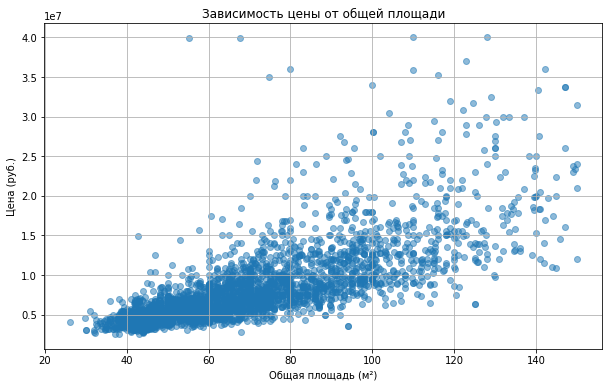

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(data['total_area'], data['last_price'], alpha=0.5)
plt.title('Зависимость цены от общей площади')
plt.xlabel('Общая площадь (м²)')
plt.ylabel('Цена (руб.)')
plt.grid()
plt.show()


<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех

Тут хочу отметить то, что подобран классный метод показа зависимости на графике. 

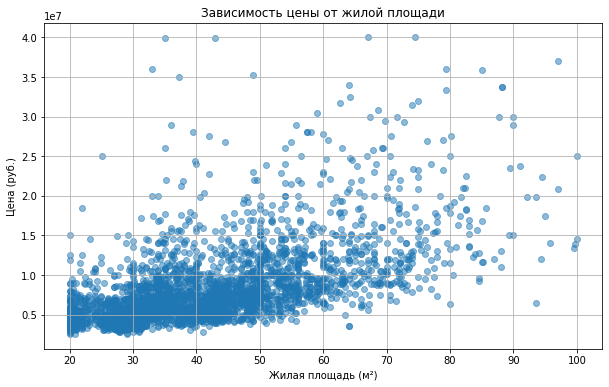

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(data['living_area'], data['last_price'], alpha=0.5)
plt.title('Зависимость цены от жилой площади')
plt.xlabel('Жилая площадь (м²)')
plt.ylabel('Цена (руб.)')
plt.grid()
plt.show()


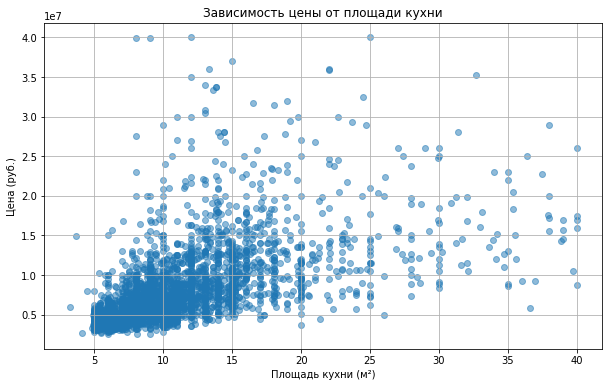

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(data['kitchen_area'], data['last_price'], alpha=0.5)
plt.title('Зависимость цены от площади кухни')
plt.xlabel('Площадь кухни (м²)')
plt.ylabel('Цена (руб.)')
plt.grid()
plt.show()


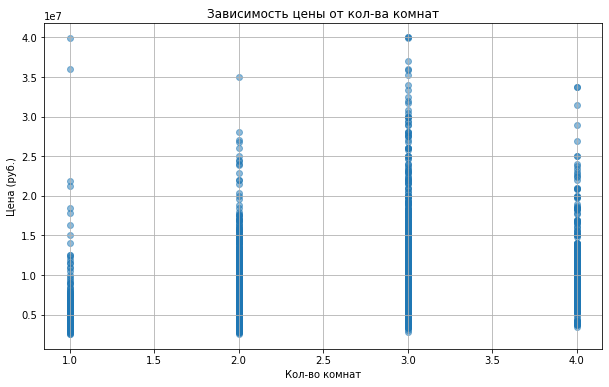

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(data['rooms'], data['last_price'], alpha=0.5)
plt.title('Зависимость цены от кол-ва комнат')
plt.xlabel('Кол-во комнат')
plt.ylabel('Цена (руб.)')
plt.grid()
plt.show()


*Вывод:* исходя из графиков, можем сделать вывод о том, что присутствует линейная зависимость между ценой и метражем (общей площадью, жилой площадью, кухонной площадью)

<div class="alert alert-block alert-danger">
 
### Комментарий ревьюера
    
#### Ошибка

А тут давай попробуем оставить выводы под граифики. В конце концов, мы ведь граифики ради выводов и используем. 

<div class="alert alert-block alert-info">
    Добавила промежуточный вывод по графикам, ниже написан полный вывод
</div>

<Figure size 720x432 with 0 Axes>

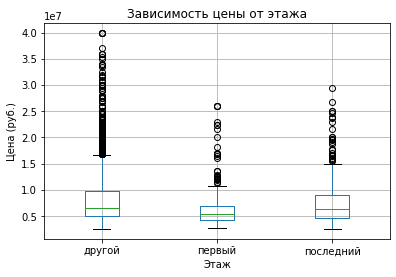

In [43]:
plt.figure(figsize=(10, 6))
data.boxplot(column='last_price', by='type_floor', grid=False)
plt.title('Зависимость цены от этажа')
plt.suptitle('')
plt.xlabel('Этаж')
plt.ylabel('Цена (руб.)')
plt.grid()
plt.show()

<Figure size 720x432 with 0 Axes>

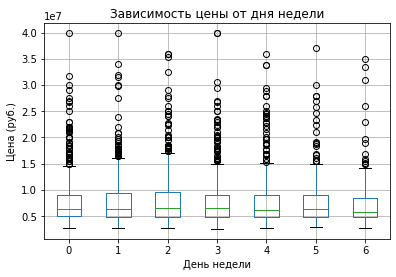

In [44]:
plt.figure(figsize=(10, 6))
data.boxplot(column='last_price', by='day_exposition', grid=False)
plt.title('Зависимость цены от дня недели')
plt.suptitle('')
plt.xlabel('День недели')
plt.ylabel('Цена (руб.)')
plt.grid()
plt.show()


<Figure size 720x432 with 0 Axes>

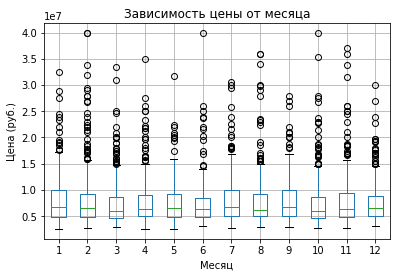

In [45]:
plt.figure(figsize=(10, 6))
data.boxplot(column='last_price', by='month_exposition', grid=False)
plt.title('Зависимость цены от месяца')
plt.suptitle('')
plt.xlabel('Месяц')
plt.ylabel('Цена (руб.)')
plt.grid()
plt.show()

<Figure size 720x432 with 0 Axes>

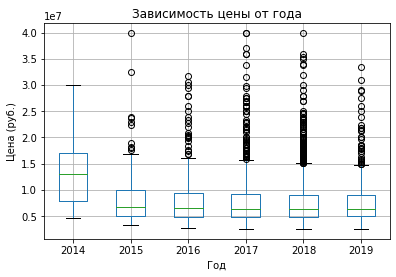

In [46]:
plt.figure(figsize=(10, 6))
data.boxplot(column='last_price', by='year_exposition', grid=False)
plt.title('Зависимость цены от года')
plt.suptitle('')
plt.xlabel('Год')
plt.ylabel('Цена (руб.)')
plt.grid()
plt.show()

<div class="alert alert-block alert-danger">
 
### Комментарий ревьюера
    
#### Ошибка

Для дня, месяца и года нет смысла считать корреляцию. У этих параметров нет линейной связи. Вывод о зависимости стоит делать толькопо графику. 

<div class="alert alert-block alert-info">
    Поняла, тогда исправила вывод, опираясь только на графики
</div>

<div class="alert alert-block alert-success">
 
# Комментарий ревьюера ver.2 
    
#### Успех

Исправлено и тут 

**Вывод:**
Цена больше всего зависит от параметров, связанных с метражем:

1. общей площади
2. жилой площади
3. площади кухни

Связь линейная: чем больше цена, тем больше метраж

Исключим то, где locality_name == 'неизвестен'

In [48]:
filtered_data = data[data['locality_name'] != 'неизвестен']

pivot_table = filtered_data.groupby('locality_name').agg(
    number_of_listings=('last_price', 'count'),  
    average_price_for_meter=('price_for_meter', 'mean') 
).reset_index()
pivot_table

,locality_name,number_of_listings,average_price_for_meter
0,Зеленогорск,8,105947.951250
1,Колпино,47,71856.186596
2,Красное Село,14,71533.545000
3,Кронштадт,37,77867.722973
4,Ломоносов,5,65634.412000
5,Павловск,9,104186.201111
6,Петергоф,63,84634.123968
7,Пушкин,90,105363.318444
8,Санкт-Петербург,3138,114617.828642
9,Сестрорецк,36,105615.681944


In [49]:
top_localities = pivot_table.nlargest(10, 'number_of_listings').reset_index(drop=True)
top_localities

,locality_name,number_of_listings,average_price_for_meter
0,Санкт-Петербург,3138,114617.828642
1,Пушкин,90,105363.318444
2,Петергоф,63,84634.123968
3,Колпино,47,71856.186596
4,Кронштадт,37,77867.722973
5,Сестрорецк,36,105615.681944
6,Красное Село,14,71533.545000
7,Павловск,9,104186.201111
8,Зеленогорск,8,105947.951250
9,Ломоносов,5,65634.412000


<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех

Рейтинг топ-10 по городам получен 

In [50]:
highest_price_locality = top_localities.loc[top_localities['average_price_for_meter'].idxmax()]
lowest_price_locality = top_localities.loc[top_localities['average_price_for_meter'].idxmin()]

In [51]:
print("Населённый пункт с самой высокой стоимостью квадратного метра:")
print(highest_price_locality)

print("Населённый пункт с самой низкой стоимостью квадратного метра:")
print(lowest_price_locality)

Населённый пункт с самой высокой стоимостью квадратного метра:
locality_name              Санкт-Петербург
number_of_listings                    3138
average_price_for_meter      114617.828642
Name: 0, dtype: object
Населённый пункт с самой низкой стоимостью квадратного метра:
locality_name              Ломоносов
number_of_listings                 5
average_price_for_meter    65634.412
Name: 9, dtype: object


In [52]:
spb_data = data[data['locality_name'] == 'Санкт-Петербург']

In [53]:
average_price_by_distance = (
    spb_data.groupby('city_center_km')['last_price'].mean().reset_index()
)
average_price_by_distance.columns = ['distance_km', 'average_price']
average_price_by_distance.head(10)

,distance_km,average_price
0,0.0,1.019800e+07
1,1.0,1.145462e+07
2,2.0,1.111262e+07
3,3.0,9.070784e+06
4,4.0,1.048559e+07
5,5.0,1.049325e+07
6,6.0,1.084233e+07
7,7.0,1.080603e+07
8,8.0,9.818939e+06
9,9.0,8.480968e+06


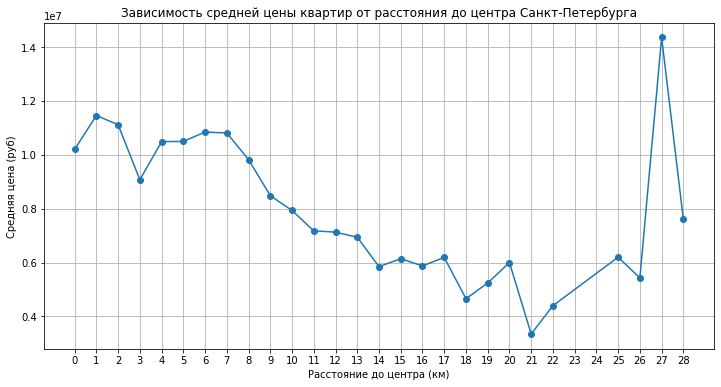

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(average_price_by_distance['distance_km'], average_price_by_distance['average_price'], marker='o')
plt.title('Зависимость средней цены квартир от расстояния до центра Санкт-Петербурга')
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Средняя цена (руб)')
plt.grid()
plt.xticks(range(int(average_price_by_distance['distance_km'].max()) + 1)) 
plt.show()

<div class="alert alert-block alert-warning">
 
### Комментарий ревьюера
    
#### Совет

А как считаешь, где заканчивается зона центра города? 

In [55]:
a = spb_data.query('city_center_km == 27')
a

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,loсality_name,price_for_meter,day_exposition,month_exposition,year_exposition,type_floor,city_center_km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5.0,30.0,3,NaN,...,0,NaN,128.0,Санкт-Петербург,193918.92,1,11,2017,другой,27.0


**Анализ результатов**

Есть зависимость: чем меньше расстояние до центра - тем выше цена

Однако, на расстояние 27км есть экстремальное значение

### Напишите общий вывод

**Этап 1**
На первом этапе я изучила датасет, ознакомившись с его структурой и содержимым. Я собрала общую информацию о столбцах и типах данных, а также построила гистограммы для всех числовых переменных.

**Этап 2**
На втором этапе я выполнила предобработке данных. Я удалила явные дубликаты, что обеспечило уникальность записей в датафрейме. Также была проведена работа с неявными дубликатами, которые могли повлиять на анализ. Также юыли заполнены нулевые значения в тех столбцах, где это было возможно.

**Этап 3**
Третий этап включал добавление новых столбцов в датафрейм, что позволило расширить объем информации для анализа.

**Этап 4**
На четвертом этапе был проведен исследовательский анализ данных:

1. *Анализ экстремальных значений(выбросов)*
с помощью построенных гистограмм

total_area: выбросы при >150м

living_area: уже обработано на прошлом этапе

kitchen_area: выбросы >40м

last_price: выбросы >0.4 * 10^8

ceiling_height: логическое изменение экстремальных значений путем деления на 10

cityCenters_nearest: выбросы >55000м

parks_nearest: выбросы >15000м

2. *Анализ среднего времени продажи*

с помощью медианных значений и квантилей

Среднее время продажи ~114 дней

Экстремально быстрые продажи до 26 дней

Экстремально долгие от 392 дней

3. *Анализ зависимости цены от параметров*

Цена больше всего зависит от параметров, связанных с метражем:

общей площади

жилой площади

площади кухни

4. *Анализ средней цены квадратного метра для населенных пунктов с наибольшем количеством объявлений*

Населённый пункт с самой высокой стоимостью квадратного метра:

Санкт-Петербург

средняя цена за квадратный метр: 114617.828642

Населённый пункт с самой низкой стоимостью квадратного метра:

Ломоносов

средняя цена за квадратный метр: 65634.412

5. *Анализ зависимости цены от расстояния до центра Санкт-Петербурга (км)*

Есть зависимость: чем меньше расстояние до центра - тем выше цена

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех

Итоговый вывод стал отличным дополнением к проекту. С таким выводом мы точно сможем составить антифрод-систему для сервиса Недвижимости. Я уверен, нам хватит для этого данных.

<div class="alert alert-block alert-info">
 
### Итоговый Комментарий ревьюера
    
#### Успех
    
Благодарю тебя за выполнение работы. Мне понравился твой проект за структурность и последовательность. Во многих местах ты подбираешь оптимальный код и автоматизируешь свою работу, а это очень пригодится в будущем. Выделить бы хотел Предобработку данных. На мой взгляд она получилась особенно удачно. Очень насыщенный итоговый вывод вышел. Старайся такие выводы делать и в будущем. 
    
    
Однако, в проекте есть несколько замечаний, которые надо исправить:

* Промежуточные выводы добавить.
* Посчитать сколько осталось уникальных значений в названиях.
* Найти и пояснить выбивающиеся значения на одном из графиков.
* Выводы под графики добавить.
* Убрать подсчет корреляции для некоторых параметров.
       
Еще я оставил рекомендации. Очень надеюсь, что ты учтешь их в этом и последующих проектах.
       
Жду проект после доработки. Уверен, ты справишься.
</div>

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.